# ECBM E4040 Project: Multi-digit Number Recognition from Street View Imagery using Deep Convolution Neural Networks

This notebook implements the following tasks:

(1) Read image data from processed pickle file and perform data preprocessing

(2) Build full model and define the functions for prediction and accuracy evaluation

(3) Initaite tensorflow session to train the model with train set and perform cross validation

(2) Load the trained model and perform tesing using test set

In [1]:
#Load necessary library
import numpy as np
from scipy import misc
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import time


## Load SVHN data

We preprocessed the image from the original SVHN datasets and saved as pickle files. This way, the file size is reduced so that we can upload to GCP and also save the time needed to read the data.

In [2]:
# Read data from pickle file
# Pickle files need to stored at the current working directory in order for this code to find the file and read it
import six.moves.cPickle as pickle
import sys
import gzip

data_dir=os.getcwd()
output_file = 'trainpkl.gz'
out_path = os.path.join(data_dir, output_file)
f_test = gzip.open(out_path, 'rb')
test_set = pickle.load(f_test)
f_test.close()


In [3]:
# Validate that we have captured all data. The full data set should have dimension (33401, 8748)
# There are 33401 images and the dimension is 54*54*3 = 8748
print(test_set['images'].shape)

(33401, 8748)


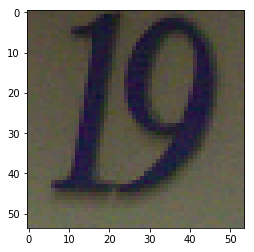

In [4]:
# Show one image from the set
plt.imshow(test_set["images"][0].reshape(54,54,3))

In [5]:
#Create labels and length list to store the digit sequence of each street number image and the length of the street number
label=[] 
length=[]
for i in range(len(test_set["labels"])):
    label.append([int(x) for x in test_set["labels"][i]])
    length.append(len(label[-1]))

## Process image data and Transform labels into proper format for training


### (1) Transform street number sequence label and length label

Because the street numbers have multiple digits and variable length, we need to perform one-hot encoding to transform the different street number into a uniform format. 

For digits in the street number, we encode the digit information in a 6 * 11 matrix. The row is the position of each digit in the street number. The column represent the digits (from 0 to 9 and the last column indicate there is not digit in that position). For example, the street number '19' will have the following matrix:

[0 1 0 0 0 0 0 0 0 0 0  
 0 0 0 0 0 0 0 0 1 0 0  
 0 0 0 0 0 0 0 0 0 0 1  
 0 0 0 0 0 0 0 0 0 0 1  
 0 0 0 0 0 0 0 0 0 0 1  
 0 0 0 0 0 0 0 0 0 0 1]  
 
 Similarly, for the length of each street number, we use one hot encoding.The length vector has 7 columns, represent length = 0 to 5 and the last column indicating more than 5. so the number '19' has length 2 and the corresponding length label vector is: [0 0 1 0 0 0 0 0].

In [6]:
#Convert the digits sequence to one hot encoding format
#The dimension of thats_hot vector is (n, 6, 11). 

Train_no = 33401 # total number of training samples
thats_hot=np.zeros((Train_no,6,11), dtype=int)
for i in range(Train_no):
    for j in range(len(label[i])):
        thats_hot[i][j][label[i][j]]=1
        for j in range(len(label[i]),6):
            thats_hot[i][j][10]=1

In [7]:
#One hot encoding of length vector
#The dimension of hot_length vector is (n, 7). 
hot_length = np.zeros((len(length), 7),dtype=int)
hot_length[np.arange(len(length),), length] = 1

### (2) Split data into training set and validation set and preprocess image

To improve accuracy, we need to substract the mean image from the feature vector. In addition, we split the training data into 20% as validation set and 80% as training.

In [8]:
#Split into train and validation set

#number of data to be used in actual training, can be changed to use small sets for hyperparemeter tuning
n=33401

#Split validation and train by 20%-80%
n_train = int(n*0.8)
Pic_crop_Final = test_set["images"]

# Substract mean image from the data and reshape
x_train = np.array(Pic_crop_Final[:n_train])
x_val = np.array(Pic_crop_Final[n_train:n])
mean_image = np.mean(x_train, axis=0)
x_train = x_train.astype(np.float32) - mean_image.astype(np.float32)
x_val = x_val.astype(np.float32) - mean_image

x_train = x_train.reshape([-1,54,54,3])
x_val = x_val.reshape([-1,54,54,3])

#Get training labels, training labels need to be in one-hot encoding format
label_train_hot= thats_hot[:n_train]
length_train_hot = hot_length[:n_train]

#Get the validation labels
#The labels used in validation and testing need to be in is original format: eg. label = [1,9], length = [2]
label_val=label[n_train:n]
length_val = length[n_train:n]



In [9]:
#Validate the dimension of training and validation set

print('Training data shape: ',x_train.shape)
print('Validation data shape: ',x_val.shape)
print('Training digits label shape: ',label_train_hot.shape)
print('Training length label shape: ',length_train_hot.shape)
# First training sample is '19'
print('Show the digits label of the first training sample:\n',label_train_hot[0])
print('Show the length label of the first training sample: ',length_train_hot[0])
print('Show the digits of the first valdation sample: ',label_val[0])
print('Show the length of the first valdation sample: ',length_val[0])


Training data shape:  (26720, 54, 54, 3)
Validation data shape:  (6681, 54, 54, 3)
Training digits label shape:  (26720, 6, 11)
Training length label shape:  (26720, 7)
Show the digits label of the first training sample:
 [[0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]]
Show the length label of the first training sample:  [0 0 1 0 0 0 0]
Show the digits of the first valdation sample:  [2]
Show the length of the first valdation sample:  1


## Define model and other function

### (1) Model structure

The model proposed by the paper have eight convolution layers, followed by two fully connected layers. This network will take the input image and transform it in to a feature vector H. Then the H vector will be the input for 6 classifiers which do independent prediction on the length, and digits. 

In [10]:
def model (x, length_labels, digits_labels, is_training=True, drop_rate=0.5):
# Input:  x: image feature, dimension  = (n * 54 * 54 * 3) 
#         length_labels: one-hot encoded of street number length, dimension = (n * 7)
#         digits_labels: one-hot encoded of street number digits, dimension = (n * 6 * 11)
#         is_training: indicate if model is in training or testing
#         drop_rate: dropout rate during training
# Output:  
#         length: dimension = (n * 7), represent the "probability" for different length
#         digits_prob: dimension = (n * 6 * 11), represent the "probability" of each digit at each position
#         loss: total cross-entropy loss of all 6 classifiers

    # Only apply dropout in training stage
    if is_training == False:
        drop_rate=0

    #CNN structure, the input image size is 54*54*3 and the filter size for each layer is [48, 64, 128, 160, 192, 192, 192, 192]
    #CNN filter size [5,5] with zero padding, and batch normalization is applied for each layer
    #max pooling is performed with stride alternating between 2 and 1, such that half of the layers reduce output the size by half
    with tf.variable_scope('CNN1'):
        conv1 = tf.layers.conv2d(x, filters=48, kernel_size=[5, 5], padding='same')
        norm1 = tf.layers.batch_normalization(conv1)
        activation1 = tf.nn.relu(norm1)
        pool1 = tf.layers.max_pooling2d(activation1, pool_size=[2, 2], strides=2, padding='same')
        layer1 = pool1
        # Output size is 27 * 27 * 48
        

    with tf.variable_scope('CNN2'):
        conv2 = tf.layers.conv2d(layer1, filters=64, kernel_size=[5, 5], padding='same')
        norm2 = tf.layers.batch_normalization(conv2)
        activation2 = tf.nn.relu(norm2)
        pool2 = tf.layers.max_pooling2d(activation2, pool_size=[2, 2], strides=1, padding='same')
        layer2 = pool2  
        #Output size is 27 * 27 * 64
        

    with tf.variable_scope('CNN3'):
        conv3 = tf.layers.conv2d(layer2, filters=128, kernel_size=[5, 5], padding='same')
        norm3 = tf.layers.batch_normalization(conv3)
        activation3 = tf.nn.relu(norm3)
        pool3 = tf.layers.max_pooling2d(activation3, pool_size=[2, 2], strides=2, padding='same')
        layer3 = pool3  
        #Output size is 14 * 14 * 128
        

    with tf.variable_scope('CNN4'):
        conv4 = tf.layers.conv2d(layer3, filters=160, kernel_size=[5, 5], padding='same')
        norm4 = tf.layers.batch_normalization(conv4)
        activation4 = tf.nn.relu(norm4)
        pool4 = tf.layers.max_pooling2d(activation4, pool_size=[2, 2], strides=1, padding='same')
        layer4 = pool4  
        # Output size is 14 * 14 *160
        

    with tf.variable_scope('CNN5'):
        conv5 = tf.layers.conv2d(layer4, filters=192, kernel_size=[5, 5], padding='same')
        norm5 = tf.layers.batch_normalization(conv5)
        activation5 = tf.nn.relu(norm5)
        pool5 = tf.layers.max_pooling2d(activation5, pool_size=[2, 2], strides=2, padding='same')
        layer5 = pool5  
        #Output size is 7 * 7 * 192
        

    with tf.variable_scope('CNN6'):
        conv6 = tf.layers.conv2d(layer5, filters=192, kernel_size=[5, 5], padding='same')
        norm6 = tf.layers.batch_normalization(conv6)
        activation6 = tf.nn.relu(norm6)
        pool6 = tf.layers.max_pooling2d(activation6, pool_size=[2, 2], strides=1, padding='same')
        layer6 = pool6  
        #Output size is 7 * 7 * 192
        

    with tf.variable_scope('CNN7'):
        conv7 = tf.layers.conv2d(layer6, filters=192, kernel_size=[5, 5], padding='same')
        norm7 = tf.layers.batch_normalization(conv7)
        activation7 = tf.nn.relu(norm7)
        pool7 = tf.layers.max_pooling2d(activation7, pool_size=[2, 2], strides=2, padding='same')
        layer7 = pool7  
        #Output size is 4 * 4 * 192
        

    with tf.variable_scope('CNN8'):
        conv8 = tf.layers.conv2d(layer7, filters=192, kernel_size=[5, 5], padding='same')
        norm8 = tf.layers.batch_normalization(conv8)
        activation8 = tf.nn.relu(norm8)
        pool8 = tf.layers.max_pooling2d(activation8, pool_size=[2, 2], strides=1, padding='same')
        layer8 = pool8  
        #Output 4 * 4 * 192

    input_to_fc = tf.reshape(layer8, [-1, 4 * 4 * 192])
    
    # feed the CNN output to two fully connected layer, units size [3072, 3072]
    # drop out is applied only in fully connected layers
    with tf.variable_scope('fc1'):
        fc1 = tf.layers.dense(input_to_fc, units=3072, activation=tf.nn.relu)
        dropout1 = tf.layers.dropout(fc1, rate=drop_rate)
        layer9 = dropout1

    with tf.variable_scope('fc2'):
        fc2 = tf.layers.dense(layer9, units=3072, activation=tf.nn.relu)
        dropout2 = tf.layers.dropout(fc2, rate=drop_rate)
        h = dropout2

    #The output of the fully connected layer is the H feature vector mentioned in the paper.
    #It is then fed into 6 different classifiers to predict length, and individual digit at each position.
    #The paper assumes the maximum length of the street number is 5 so we only have 5 classifers for digits
    
    with tf.variable_scope('digit1'):
        digit1 = tf.layers.dense(h, units=11)

    with tf.variable_scope('digit2'):
        digit2 = tf.layers.dense(h, units=11)

    with tf.variable_scope('digit3'):
        digit3 = tf.layers.dense(h, units=11)

    with tf.variable_scope('digit4'):
        digit4 = tf.layers.dense(h, units=11)

    with tf.variable_scope('digit5'):
        digit5 = tf.layers.dense(h, units=11)

    with tf.variable_scope('length'):
        length = tf.layers.dense(h, units=7)
    
    # Combine the probability prediction of each digit
    digits_prob = tf.stack([digit1, digit2, digit3, digit4, digit5], axis=1)

    # Calculate the cross entropy loss
    with tf.name_scope("loss"):
        length_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=length_labels, logits=length))
        digit1_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=digits_labels[:, 0], logits=digits_prob[:, 0, :]))
        digit2_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=digits_labels[:, 1], logits=digits_prob[:, 1, :]))
        digit3_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=digits_labels[:, 2], logits=digits_prob[:, 2, :]))
        digit4_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=digits_labels[:, 3], logits=digits_prob[:, 3, :]))
        digit5_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=digits_labels[:, 4], logits=digits_prob[:, 4, :]))
        total_loss = length_loss + digit1_loss + digit2_loss + digit3_loss + digit4_loss + digit5_loss
    
    return length, digits_prob, total_loss

### (2) Function to predict the length and digits at each position

The model above return two vectors: length (n,7) and digit_prob at each position (n,5,11). These vectors will be transformed into probailities using softmax. The prediction function will then predict the length based on the overall probability:
![overall probability](./prob.PNG)

Instead of calculating the product of all probabilities, we calculate the sum of the log to avoid diminishing probability issue. It also return the digit prediction at each position by choosing the number that have the highest probability at each position.

In [11]:
def predict (length_logits, digits_logits):
# Input:  length_logits: dimension(n * 7), to be converted probabilities with softmax function
#         digits_logits: dimension (n * 5 * 11), to be converted to probabilities with softmax function
# Output: length_prediction: dimension(n * 1), predicted length for each sample
#         digits_prediction: size (n * 5 ), predicted digits at each position

    with tf.name_scope('predict'):
        # Convert the input to probability using softmax and take log
        p_l =tf.log(tf.nn.softmax(length_logits,axis=1))
        p_d1=tf.log(tf.nn.softmax(digits_logits[:, 0, :],axis=1))
        p_d2=tf.log(tf.nn.softmax(digits_logits[:, 1, :],axis=1))
        p_d3=tf.log(tf.nn.softmax(digits_logits[:, 2, :],axis=1))
        p_d4=tf.log(tf.nn.softmax(digits_logits[:, 3, :],axis=1))
        p_d5=tf.log(tf.nn.softmax(digits_logits[:, 4, :],axis=1))
        
        # Calculate overall log_P(S) of the sequence for different length (L = 0, 1, 2, 3, 4, 5, >5)
        # by summing up the probability of the length and probabilites of each digit
        ps0 = tf.add_n([p_l[:,0]])
        ps1= tf.add_n([p_l[:,1],tf.reduce_max(p_d1,axis = 1)])
        ps2= tf.add_n([p_l[:,2],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1)])
        ps3= tf.add_n([p_l[:,3],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1),tf.reduce_max(p_d3,axis = 1)])
        ps4= tf.add_n([p_l[:,4],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1),tf.reduce_max(p_d3,axis = 1),tf.reduce_max(p_d4,axis = 1)])
        ps5= tf.add_n([p_l[:,5],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1),tf.reduce_max(p_d3,axis = 1),tf.reduce_max(p_d4,axis = 1),tf.reduce_max(p_d5,axis = 1)])
        ps6= tf.add_n([p_l[:,6],tf.reduce_max(p_d1,axis = 1),tf.reduce_max(p_d2,axis = 1),tf.reduce_max(p_d3,axis = 1),tf.reduce_max(p_d4,axis = 1),tf.reduce_max(p_d5,axis = 1)])
        
        #The predicted length is the one with the highest overall log_P(S)
        ps = tf.stack([ps0,ps1, ps2, ps3, ps4, ps5,ps6], axis=1)
        length_predictions =tf.argmax(ps,axis=1)
        
        #Pick the most possible digit at each position
        d1 = tf.argmax(p_d1, axis=1)
        d2 = tf.argmax(p_d2, axis=1)
        d3 = tf.argmax(p_d3, axis=1)
        d4 = tf.argmax(p_d4, axis=1)
        d5 = tf.argmax(p_d5, axis=1)
        digits_prediction = tf.stack([d1, d2, d3, d4, d5], axis=1)

    return length_predictions,digits_prediction

### (3) Function to compare the predicted street number and calculate accuracy


In [12]:
def evaluate (length_predictions, digits_predictions, length_label, label):

# Input:  length_label: list of length for each street number, dimension = (n,1)
#         label: list of individual digits of each street number
#         length_predictions: numpy array of predicted length for each sample
#         digits_predictions: numpy array of predicted 5 digits for each sample
# Output: 
#         output_list: list of predicted street number
#         accuracy: prediction accuracy

    output_list = []
    num_error = 0
    for i in range(len(length_label)):
        str_pred = np.ndarray.tolist(digits_predictions[i,:length_predictions[i]])
        output_list.append(str_pred)
        if str_pred != label[i]:
            num_error+=1
    accuracy = (1-num_error/len(length_label))*100
    return output_list, accuracy

## Training and Hyper-parameter tuning

In this session, we create the training session to train the model. However, due to the long computation time, we first test out different combination of hyper parameters using a subset of 3000 samples and we select the one with best performance. Then, training is done on the full set using the best hyper parameters.

In [23]:
# Pick a subset of full data to be used in hyper parameter tuning

#number of data to be used in hyperparemeter tuning
n_tune=3000

#Split validation and train by 20%-80%
n_tune_train = int(n_tune*0.8)

# Substract mean image from the data and reshape
x_tune_train = np.array(Pic_crop_Final[:n_tune_train])
x_tune_val = np.array(Pic_crop_Final[n_tune_train:n_tune])
mean_image_tune = np.mean(x_tune_train, axis=0)
x_tune_train = x_tune_train.astype(np.float32) - mean_image_tune.astype(np.float32)
x_tune_val = x_tune_val.astype(np.float32) - mean_image_tune

x_tune_train = x_tune_train.reshape([-1,54,54,3])
x_tune_val = x_tune_val.reshape([-1,54,54,3])

#Get training labels, training labels need to be in one-hot encoding format
label_tune_train_hot= thats_hot[:n_tune_train]
length_tune_train_hot = hot_length[:n_tune_train]

#Get the validation labels
#The labels used in validation and testing need to be in is original format: eg. label = [1,9], length = [2]
label_tune_val=label[n_tune_train:n_tune]
length_tune_val = length[n_tune_train:n_tune]


In [24]:
print('Training data shape: ',x_tune_train.shape)
print('Validation data shape: ',x_tune_val.shape)
print('Training digits label shape: ',label_tune_train_hot.shape)
print('Training length label shape: ',length_tune_train_hot.shape)
# First training sample is '19'
print('Show the digits label of the first training sample:\n',label_tune_train_hot[0])
print('Show the length label of the first training sample: ',length_tune_train_hot[0])
print('Show the digits of the first valdation sample: ',label_tune_val[0])
print('Show the length of the first valdation sample: ',length_tune_val[0])

Training data shape:  (2400, 54, 54, 3)
Validation data shape:  (600, 54, 54, 3)
Training digits label shape:  (2400, 6, 11)
Training length label shape:  (2400, 7)
Show the digits label of the first training sample:
 [[0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]]
Show the length label of the first training sample:  [0 0 1 0 0 0 0]
Show the digits of the first valdation sample:  [1, 0]
Show the length of the first valdation sample:  2


In [ ]:
#Initiate training Session for different combination of hyper parameters
param = [[16, 1e-4, 0.2],[16, 1e-4, 0.5],[16, 1e-3, 0.5],[16, 1e-2, 0.2], [16, 1e-2, 0.5]]
for p in range(len(param)):
    tf.reset_default_graph()
    with tf.name_scope('inputs'):
        x = tf.placeholder(tf.float32, shape=(None,54,54,3))
        length_labels = tf.placeholder(tf.int64, shape=(None,None,))
        digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))
        is_training = tf.placeholder(tf.bool, name='is_training')

    num_train = x_tune_train.shape[0]
    batch_size = param[p][0]
    epoches = 100
    num_batch = num_train//batch_size
    learning_rate = param[p][1]
    drop_rate = param[p][2]
    length_logits, digits_logits, loss = model(x, length_labels, digits_labels, drop_rate)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    length_predictions, digits_predictions = predict(length_logits, digits_logits)

    iter_total = 0
    best_acc = 0
    cur_model_name = 'SVHN_{}'.format(int(time.time()))
    pre_trained_model = ''

    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        saver = tf.train.Saver()
        if pre_trained_model != '':
            saver.restore(sess, pre_trained_model)
        tic = time.time()
        for e in range(epoches):
            print("epoch {} ".format(e + 1))
            for i in range(num_batch):
                iter_total += 1
                choice=np.random.choice(num_train, size=batch_size, replace=False)
                batch_x, batch_digits, batch_length = x_tune_train[choice], label_tune_train_hot[choice], length_tune_train_hot[choice]
                _, length_logits_tf, digits_logits_tf, loss_tf = sess.run([train_step,length_logits, digits_logits, loss],
                                                                          feed_dict={x:batch_x , 
                                                                                     length_labels:batch_length,
                                                                                     digits_labels:batch_digits,
                                                                                     is_training: True})


                if iter_total % 50 == 0:

                # do validation
                    length_tf, digit_tf = sess.run([length_predictions, digits_predictions],feed_dict={x:x_tune_val, is_training: False})
                    pred_str, valid_acc = evaluate(length_tf, digit_tf, length_tune_val, label_tune_val)
                    print('{} batch training loss: {} validation accuracy : {}%'.format(i+1,loss_tf,valid_acc))

                    # when achieve the best validation accuracy, we store the model paramters
                    if valid_acc > best_acc:
                        best_acc = valid_acc
                        print('Best validation accuracy: {}%'.format(best_acc))

                        #saver.save(sess, 'model/{}'.format(cur_model_name))
    print("Training ends for param {}. The best valid accuracy is {}. Model named {}.".format(p,best_acc, cur_model_name))
    toc = time.time()
    duration = toc-tic
    if duration > 60:
        duration_m = int(duration / 60)
        duration_s = duration-duration_m*60
        print("Total time is {} minutes, {} seconds.".format(duration_m, duration_s))
    else:
        print("Total time is {} seconds.".format(duration))


epoch 1 
50 batch training loss: 6.5499396324157715 validation accuracy : 1.6666666666666718%
Best validation accuracy: 1.6666666666666718%
100 batch training loss: 6.424825668334961 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.949575424194336 validation accuracy : 1.6666666666666718%
epoch 2 
50 batch training loss: 6.642295837402344 validation accuracy : 2.6666666666666616%
Best validation accuracy: 2.6666666666666616%
100 batch training loss: 5.532802581787109 validation accuracy : 3.166666666666662%
Best validation accuracy: 3.166666666666662%
150 batch training loss: 5.7879958152771 validation accuracy : 5.333333333333334%
Best validation accuracy: 5.333333333333334%
epoch 3 
50 batch training loss: 5.739106178283691 validation accuracy : 4.333333333333334%
100 batch training loss: 4.0238566398620605 validation accuracy : 6.499999999999995%
Best validation accuracy: 6.499999999999995%
150 batch training loss: 4.0165629386901855 validation accuracy : 9.99999

100 batch training loss: 0.13941776752471924 validation accuracy : 50.33333333333334%
150 batch training loss: 0.005743511952459812 validation accuracy : 53.16666666666667%
Best validation accuracy: 53.16666666666667%
epoch 29 
50 batch training loss: 0.23143725097179413 validation accuracy : 53.333333333333336%
Best validation accuracy: 53.333333333333336%
100 batch training loss: 0.12429642677307129 validation accuracy : 49.16666666666667%
150 batch training loss: 0.15489286184310913 validation accuracy : 50.0%
epoch 30 
50 batch training loss: 0.4642501771450043 validation accuracy : 47.5%
100 batch training loss: 0.03520389646291733 validation accuracy : 50.16666666666667%
150 batch training loss: 0.04125477001070976 validation accuracy : 50.5%
epoch 31 
50 batch training loss: 0.2071588933467865 validation accuracy : 49.83333333333333%
100 batch training loss: 0.017446493729948997 validation accuracy : 51.83333333333333%
150 batch training loss: 0.0014523400459438562 validation ac

50 batch training loss: 0.0016446373192593455 validation accuracy : 52.16666666666667%
100 batch training loss: 0.577144205570221 validation accuracy : 48.66666666666667%
150 batch training loss: 0.22512929141521454 validation accuracy : 51.5%
epoch 61 
50 batch training loss: 0.07555560767650604 validation accuracy : 49.5%
100 batch training loss: 0.3452177047729492 validation accuracy : 50.33333333333334%
150 batch training loss: 0.04686993360519409 validation accuracy : 53.0%
epoch 62 
50 batch training loss: 0.002630822826176882 validation accuracy : 51.0%
100 batch training loss: 0.11733295023441315 validation accuracy : 52.16666666666667%
150 batch training loss: 0.0005123845767229795 validation accuracy : 52.16666666666667%
epoch 63 
50 batch training loss: 0.05966302007436752 validation accuracy : 53.333333333333336%
100 batch training loss: 0.0058162398636341095 validation accuracy : 53.16666666666667%
150 batch training loss: 0.10814602673053741 validation accuracy : 54.66666

100 batch training loss: 0.0007644664729014039 validation accuracy : 50.83333333333333%
150 batch training loss: 0.02264697663486004 validation accuracy : 49.33333333333333%
epoch 92 
50 batch training loss: 0.003141741268336773 validation accuracy : 50.83333333333333%
100 batch training loss: 0.05781581252813339 validation accuracy : 52.666666666666664%
150 batch training loss: 0.012242026627063751 validation accuracy : 51.5%
epoch 93 
50 batch training loss: 0.04117480665445328 validation accuracy : 52.0%
100 batch training loss: 0.8500918745994568 validation accuracy : 51.5%
150 batch training loss: 0.0003040873270947486 validation accuracy : 52.33333333333333%
epoch 94 
50 batch training loss: 0.008297467604279518 validation accuracy : 51.66666666666666%
100 batch training loss: 0.00031240444513969123 validation accuracy : 52.666666666666664%
150 batch training loss: 0.005835711024701595 validation accuracy : 53.333333333333336%
epoch 95 
50 batch training loss: 0.00010553118045208

150 batch training loss: 0.10571742802858353 validation accuracy : 48.83333333333333%
epoch 19 
50 batch training loss: 0.1692538857460022 validation accuracy : 45.333333333333336%
100 batch training loss: 0.6315264105796814 validation accuracy : 45.333333333333336%
150 batch training loss: 0.09505245089530945 validation accuracy : 50.16666666666667%
epoch 20 
50 batch training loss: 0.13800503313541412 validation accuracy : 47.16666666666667%
100 batch training loss: 0.22329311072826385 validation accuracy : 47.5%
150 batch training loss: 0.39852723479270935 validation accuracy : 47.66666666666667%
epoch 21 
50 batch training loss: 0.4395580291748047 validation accuracy : 47.16666666666667%
100 batch training loss: 0.0674079954624176 validation accuracy : 46.833333333333336%
150 batch training loss: 0.4002857506275177 validation accuracy : 45.833333333333336%
epoch 22 
50 batch training loss: 0.29863885045051575 validation accuracy : 48.83333333333333%
100 batch training loss: 0.03649

50 batch training loss: 0.10122232139110565 validation accuracy : 52.0%
100 batch training loss: 0.020141160115599632 validation accuracy : 51.33333333333333%
150 batch training loss: 0.06010991334915161 validation accuracy : 49.16666666666667%
epoch 51 
50 batch training loss: 0.2765237092971802 validation accuracy : 47.333333333333336%
100 batch training loss: 0.0882544293999672 validation accuracy : 48.0%
150 batch training loss: 0.05622386187314987 validation accuracy : 46.0%
epoch 52 
50 batch training loss: 0.018266310915350914 validation accuracy : 50.83333333333333%
100 batch training loss: 0.005160948261618614 validation accuracy : 52.16666666666667%
150 batch training loss: 0.02336970344185829 validation accuracy : 51.0%
epoch 53 
50 batch training loss: 0.048337146639823914 validation accuracy : 48.5%
100 batch training loss: 0.1280350536108017 validation accuracy : 52.0%
150 batch training loss: 0.016954628750681877 validation accuracy : 46.166666666666664%
epoch 54 
50 bat

150 batch training loss: 0.008574798703193665 validation accuracy : 50.83333333333333%
epoch 82 
50 batch training loss: 0.03802008554339409 validation accuracy : 52.16666666666667%
100 batch training loss: 0.015329677611589432 validation accuracy : 52.0%
150 batch training loss: 0.03515266999602318 validation accuracy : 51.33333333333333%
epoch 83 
50 batch training loss: 0.008616921491920948 validation accuracy : 51.83333333333333%
100 batch training loss: 0.0003028798964805901 validation accuracy : 52.0%
150 batch training loss: 0.0006189604755491018 validation accuracy : 52.0%
epoch 84 
50 batch training loss: 0.00630258210003376 validation accuracy : 51.66666666666666%
100 batch training loss: 0.8199874758720398 validation accuracy : 51.66666666666666%
150 batch training loss: 0.0010699349222704768 validation accuracy : 50.66666666666666%
epoch 85 
50 batch training loss: 0.0031957419123500586 validation accuracy : 50.66666666666666%
100 batch training loss: 0.0005027368315495551 

150 batch training loss: 7.486856937408447 validation accuracy : 1.6666666666666718%
epoch 13 
50 batch training loss: 6.887628078460693 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.438808441162109 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.60947847366333 validation accuracy : 1.6666666666666718%
epoch 14 
50 batch training loss: 7.6592698097229 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.825847625732422 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.420337200164795 validation accuracy : 1.6666666666666718%
epoch 15 
50 batch training loss: 6.872352123260498 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.499239921569824 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.890622138977051 validation accuracy : 1.6666666666666718%
epoch 16 
50 batch training loss: 6.650751113891602 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.01568

50 batch training loss: 7.440732955932617 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.992530345916748 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.6456379890441895 validation accuracy : 1.6666666666666718%
epoch 45 
50 batch training loss: 6.967555999755859 validation accuracy : 1.6666666666666718%
100 batch training loss: 6.665798664093018 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.189447402954102 validation accuracy : 1.6666666666666718%
epoch 46 
50 batch training loss: 6.584399700164795 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.104293346405029 validation accuracy : 1.6666666666666718%
150 batch training loss: 7.252655982971191 validation accuracy : 1.6666666666666718%
epoch 47 
50 batch training loss: 6.775731086730957 validation accuracy : 1.6666666666666718%
100 batch training loss: 7.736502647399902 validation accuracy : 1.6666666666666718%
150 batch training loss: 6.39440298080

In [14]:
#Initiate training Session for different combination of hyper parameters on full data
param = [[16, 1e-3, 0.2],[16, 1e-3, 0.8],[16, 1e-2, 0.8], [32, 1e-4, 0.8], [32, 1e-3, 0.8], [32, 1e-2, 0.8]]
for p in range(len(param)):
    tf.reset_default_graph()
    with tf.name_scope('inputs'):
        x = tf.placeholder(tf.float32, shape=(None,54,54,3))
        length_labels = tf.placeholder(tf.int64, shape=(None,None,))
        digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))
        is_training = tf.placeholder(tf.bool, name='is_training')

    num_train = x_train.shape[0]
    batch_size = param[p][0]
    epoches = 20
    num_batch = num_train//batch_size
    learning_rate = param[p][1]
    drop_rate = param[p][2]
    length_logits, digits_logits, loss = model(x, length_labels, digits_labels, drop_rate)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    length_predictions, digits_predictions = predict(length_logits, digits_logits)

    iter_total = 0
    best_acc = 0
    cur_model_name = 'SVHN_{}'.format(int(time.time()))
    pre_trained_model = ''

    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        saver = tf.train.Saver()
        if pre_trained_model != '':
            saver.restore(sess, pre_trained_model)
        tic = time.time()
        for e in range(epoches):
            print("epoch {} ".format(e + 1))
            for i in range(num_batch):
                iter_total += 1
                choice=np.random.choice(num_train, size=batch_size, replace=False)
                batch_x, batch_digits, batch_length = x_train[choice], label_train_hot[choice], length_train_hot[choice]
                _, length_logits_tf, digits_logits_tf, loss_tf = sess.run([train_step,length_logits, digits_logits, loss],
                                                                          feed_dict={x:batch_x , 
                                                                                     length_labels:batch_length,
                                                                                     digits_labels:batch_digits,
                                                                                     is_training: True})


                if iter_total % 200 == 0:

                # do validation
                    length_tf, digit_tf = sess.run([length_predictions, digits_predictions],feed_dict={x:x_val, is_training: False})
                    pred_str, valid_acc = evaluate(length_tf, digit_tf, length_val, label_val)
                    print('{} batch training loss: {} validation accuracy : {}%'.format(i+1,loss_tf,valid_acc))

                    # when achieve the best validation accuracy, we store the model paramters
                    if valid_acc > best_acc:
                        best_acc = valid_acc
                        print('Best validation accuracy: {}%'.format(best_acc))

                        saver.save(sess, 'model/{}'.format(cur_model_name))
    print("Training ends for param {}. The best valid accuracy is {}. Model named {}.".format(p,best_acc, cur_model_name))
    toc = time.time()
    duration = toc-tic
    if duration > 60:
        duration_m = int(duration / 60)
        duration_s = duration-duration_m*60
        print("Total time is {} minutes, {} seconds.".format(duration_m, duration_s))
    else:
        print("Total time is {} seconds.".format(duration))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

epoch 1 
200 batch training loss: 7.095887184143066 validation accuracy : 2.260140697500379%
Best validation accuracy: 2.260140697500379%
400 batch training loss: 7.7409586906433105 validation accuracy : 1.856009579404283%
600 batch training loss: 6.633730411529541 validation accuracy : 2.260140697500379%
800 batch training loss: 7.136918544769287 validation accuracy : 2.260140697500379%
1000 batch training loss: 6.865479946136475 validation accuracy : 2.260140697500379%
1200 batch training loss: 7.609001636505127 validation accuracy : 2.260140697500379%
1400 batch training loss: 8.884620666503906 validation accuracy : 2.260140697500379%
1600 batch training loss: 7.199562072753906 validation accuracy : 2.260140697500379%
epoch 2 
130 batch training loss: 6.371532440185547 validation accuracy : 2.2

epoch 12 
30 batch training loss: 6.759761333465576 validation accuracy : 2.260140697500379%
230 batch training loss: 7.321661949157715 validation accuracy : 2.260140697500379%
430 batch training loss: 7.028294086456299 validation accuracy : 2.260140697500379%
630 batch training loss: 7.256536483764648 validation accuracy : 2.260140697500379%
830 batch training loss: 6.664183139801025 validation accuracy : 2.260140697500379%
1030 batch training loss: 8.876826286315918 validation accuracy : 2.260140697500379%
1230 batch training loss: 7.507907867431641 validation accuracy : 2.260140697500379%
1430 batch training loss: 6.595025539398193 validation accuracy : 2.260140697500379%
1630 batch training loss: 8.168893814086914 validation accuracy : 2.260140697500379%
epoch 13 
160 batch training loss: 6.767789840698242 validation accuracy : 2.260140697500379%
360 batch training loss: 5.901428699493408 validation accuracy : 2.260140697500379%
560 batch training loss: 7.616733074188232 validation

1330 batch training loss: 3.856637954711914 validation accuracy : 15.895823978446344%
Best validation accuracy: 15.895823978446344%
1530 batch training loss: 3.81768536567688 validation accuracy : 17.09324951354587%
Best validation accuracy: 17.09324951354587%
epoch 3 
60 batch training loss: 5.634470462799072 validation accuracy : 16.599311480317315%
260 batch training loss: 3.8093035221099854 validation accuracy : 15.087561742254152%
460 batch training loss: 3.60784649848938 validation accuracy : 25.205807513845237%
Best validation accuracy: 25.205807513845237%
660 batch training loss: 2.807961940765381 validation accuracy : 27.840143691064213%
Best validation accuracy: 27.840143691064213%
860 batch training loss: 3.5240745544433594 validation accuracy : 27.795240233497974%
1060 batch training loss: 1.5851280689239502 validation accuracy : 31.118096093399195%
Best validation accuracy: 31.118096093399195%
1260 batch training loss: 3.2529778480529785 validation accuracy : 33.5728184403

epoch 12 
30 batch training loss: 0.5936988592147827 validation accuracy : 69.07648555605448%
Best validation accuracy: 69.07648555605448%
230 batch training loss: 2.0360043048858643 validation accuracy : 67.2504116150277%
430 batch training loss: 0.6938225626945496 validation accuracy : 69.40577757820685%
Best validation accuracy: 69.40577757820685%
630 batch training loss: 0.8767458200454712 validation accuracy : 68.41790151174973%
830 batch training loss: 0.8276679515838623 validation accuracy : 69.91468343062415%
Best validation accuracy: 69.91468343062415%
1030 batch training loss: 1.303484559059143 validation accuracy : 69.61532704684927%
1230 batch training loss: 2.056792736053467 validation accuracy : 69.4207453973956%
1430 batch training loss: 1.3187464475631714 validation accuracy : 69.58539140847179%
1630 batch training loss: 2.4560556411743164 validation accuracy : 68.94177518335579%
epoch 13 
160 batch training loss: 0.42998558282852173 validation accuracy : 70.04939380332

930 batch training loss: 8.190679550170898 validation accuracy : 2.260140697500379%
1130 batch training loss: 6.918704032897949 validation accuracy : 2.260140697500379%
1330 batch training loss: 7.359154224395752 validation accuracy : 2.260140697500379%
1530 batch training loss: 7.808662414550781 validation accuracy : 2.260140697500379%
epoch 3 
60 batch training loss: 7.500259876251221 validation accuracy : 2.260140697500379%
260 batch training loss: 7.169668674468994 validation accuracy : 2.260140697500379%
460 batch training loss: 7.789423942565918 validation accuracy : 2.260140697500379%
660 batch training loss: 7.9772629737854 validation accuracy : 2.260140697500379%
860 batch training loss: 7.406440734863281 validation accuracy : 2.260140697500379%
1060 batch training loss: 5.9554443359375 validation accuracy : 2.260140697500379%
1260 batch training loss: 7.004324436187744 validation accuracy : 2.260140697500379%
1460 batch training loss: 6.849054336547852 validation accuracy : 2

epoch 14 
90 batch training loss: 7.805848598480225 validation accuracy : 2.260140697500379%
290 batch training loss: 7.470821857452393 validation accuracy : 2.260140697500379%
490 batch training loss: 6.420314788818359 validation accuracy : 2.260140697500379%
690 batch training loss: 5.667623519897461 validation accuracy : 2.260140697500379%
890 batch training loss: 7.077061653137207 validation accuracy : 2.260140697500379%
1090 batch training loss: 7.13474178314209 validation accuracy : 2.260140697500379%
1290 batch training loss: 8.643271446228027 validation accuracy : 2.260140697500379%
1490 batch training loss: 7.423191547393799 validation accuracy : 2.260140697500379%
epoch 15 
20 batch training loss: 7.693782806396484 validation accuracy : 2.260140697500379%
220 batch training loss: 6.593553066253662 validation accuracy : 2.260140697500379%
420 batch training loss: 5.693207263946533 validation accuracy : 2.260140697500379%
620 batch training loss: 8.209385871887207 validation ac

190 batch training loss: 0.3463808298110962 validation accuracy : 78.16195180362222%
Best validation accuracy: 78.16195180362222%
390 batch training loss: 0.8276932239532471 validation accuracy : 76.18619967070798%
590 batch training loss: 1.0727221965789795 validation accuracy : 77.77278850471487%
790 batch training loss: 0.37647974491119385 validation accuracy : 78.49124382577457%
Best validation accuracy: 78.49124382577457%
epoch 8 
155 batch training loss: 0.20344290137290955 validation accuracy : 78.68582547522827%
Best validation accuracy: 78.68582547522827%
355 batch training loss: 0.9468101263046265 validation accuracy : 79.64376590330788%
Best validation accuracy: 79.64376590330788%
555 batch training loss: 0.042060207575559616 validation accuracy : 78.49124382577457%
755 batch training loss: 0.5597193241119385 validation accuracy : 78.44634036820835%
epoch 9 
120 batch training loss: 0.5607991218566895 validation accuracy : 77.50336775931747%
320 batch training loss: 0.082596

225 batch training loss: 2.6849961280822754 validation accuracy : 57.98533153719503%
Best validation accuracy: 57.98533153719503%
425 batch training loss: 1.887001395225525 validation accuracy : 58.61397994312229%
Best validation accuracy: 58.61397994312229%
625 batch training loss: 1.9514943361282349 validation accuracy : 60.11076186199671%
Best validation accuracy: 60.11076186199671%
825 batch training loss: 1.5026655197143555 validation accuracy : 60.27540787307289%
Best validation accuracy: 60.27540787307289%
epoch 7 
190 batch training loss: 1.8750125169754028 validation accuracy : 59.66172728633439%
390 batch training loss: 1.097685694694519 validation accuracy : 62.68522676246071%
Best validation accuracy: 62.68522676246071%
590 batch training loss: 1.7105796337127686 validation accuracy : 61.442897769794946%
790 batch training loss: 1.5451745986938477 validation accuracy : 61.5626403233049%
epoch 8 
155 batch training loss: 2.3138279914855957 validation accuracy : 62.2661278251

460 batch training loss: 7.148595809936523 validation accuracy : 2.260140697500379%
660 batch training loss: 7.188445568084717 validation accuracy : 2.260140697500379%
epoch 6 
25 batch training loss: 7.434535980224609 validation accuracy : 2.260140697500379%
225 batch training loss: 7.739614486694336 validation accuracy : 2.260140697500379%
425 batch training loss: 7.11812162399292 validation accuracy : 2.260140697500379%
625 batch training loss: 7.216722011566162 validation accuracy : 2.260140697500379%
825 batch training loss: 7.193448543548584 validation accuracy : 2.260140697500379%
epoch 7 
190 batch training loss: 7.446338653564453 validation accuracy : 2.260140697500379%
390 batch training loss: 6.503403663635254 validation accuracy : 2.260140697500379%
590 batch training loss: 6.8737287521362305 validation accuracy : 2.260140697500379%
790 batch training loss: 6.787829399108887 validation accuracy : 2.260140697500379%
epoch 8 
155 batch training loss: 7.080641746520996 validat

In [17]:
#Initiate training Session on longer epoch

tf.reset_default_graph()
with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, shape=(None,54,54,3))
    length_labels = tf.placeholder(tf.int64, shape=(None,None,))
    digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))
    is_training = tf.placeholder(tf.bool, name='is_training')

num_train = x_train.shape[0]
batch_size = 16
epoches = 50
num_batch = num_train//batch_size
learning_rate = 1e-4
drop_rate = 0.7
length_logits, digits_logits, loss = model(x, length_labels, digits_labels, drop_rate)

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

length_predictions, digits_predictions = predict(length_logits, digits_logits)

iter_total = 0
best_acc = 0
cur_model_name = 'SVHN_{}'.format(int(time.time()))
pre_trained_model = ''

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver = tf.train.Saver()
    if pre_trained_model != '':
        saver.restore(sess, pre_trained_model)
    tic = time.time()
    for e in range(epoches):
        print("epoch {} ".format(e + 1))
        for i in range(num_batch):
            iter_total += 1
            choice=np.random.choice(num_train, size=batch_size, replace=False)
            batch_x, batch_digits, batch_length = x_train[choice], label_train_hot[choice], length_train_hot[choice]
            _, length_logits_tf, digits_logits_tf, loss_tf = sess.run([train_step,length_logits, digits_logits, loss],
                                                                      feed_dict={x:batch_x , 
                                                                                 length_labels:batch_length,
                                                                                 digits_labels:batch_digits,
                                                                                 is_training: True})
            

            if iter_total % 500 == 0:
                
            # do validation
                length_tf, digit_tf = sess.run([length_predictions, digits_predictions],feed_dict={x:x_val, is_training: False})
                pred_str, valid_acc = evaluate(length_tf, digit_tf, length_val, label_val)
                print('{} batch training loss: {} validation accuracy : {}%'.format(i+1,loss_tf,valid_acc))

                # when achieve the best validation accuracy, we store the model paramters
                if valid_acc > best_acc:
                    best_acc = valid_acc
                    print('Best validation accuracy: {}%'.format(best_acc))
                
                    saver.save(sess, 'model/{}'.format(cur_model_name))
print("Training ends. The best valid accuracy is {}. Model named {}.".format(best_acc, cur_model_name))
toc = time.time()
duration = toc-tic
if duration > 60:
    duration_m = int(duration / 60)
    duration_s = duration-duration_m*60
    print("Total time is {} minutes, {} seconds.".format(duration_m, duration_s))
else:
    print("Total time is {} seconds.".format(duration))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

epoch 1 
100 batch training loss: 7.471405506134033 validation accuracy : 2.00568777129172%
Best validation accuracy: 2.00568777129172%
200 batch training loss: 7.078288555145264 validation accuracy : 2.334979793444092%
Best validation accuracy: 2.334979793444092%
300 batch training loss: 6.258343696594238 validation accuracy : 3.861697350696003%
Best validation accuracy: 3.861697350696003%
400 batch training loss: 5.750016689300537 validation accuracy : 4.684927406076933%
Best validation accuracy: 4.684927406076933%
500 batch training loss: 5.731884002685547 validation accuracy : 8.576560395150423%
Best validation accuracy: 8.576560395150423%
600 batch training loss: 4.853463649749756 validation accuracy : 8.995659332435268%
Best validation accuracy: 8.995659332435268%
700 batch training loss: 6.

620 batch training loss: 0.48123297095298767 validation accuracy : 76.79988025744649%
Best validation accuracy: 76.79988025744649%
720 batch training loss: 0.7907704710960388 validation accuracy : 76.51549169286035%
820 batch training loss: 0.6144750118255615 validation accuracy : 76.79988025744649%
920 batch training loss: 0.5932834148406982 validation accuracy : 77.413560844185%
Best validation accuracy: 77.413560844185%
1020 batch training loss: 1.2645418643951416 validation accuracy : 76.66516988474778%
1120 batch training loss: 0.15294575691223145 validation accuracy : 77.24891483310881%
1220 batch training loss: 0.3469359278678894 validation accuracy : 75.30309833857207%
1320 batch training loss: 1.4394232034683228 validation accuracy : 76.3957491393504%
1420 batch training loss: 0.397671639919281 validation accuracy : 77.00942972608891%
1520 batch training loss: 0.2303050309419632 validation accuracy : 76.69510552312528%
1620 batch training loss: 0.30591845512390137 validation a

1470 batch training loss: 0.0674760490655899 validation accuracy : 78.67085765603952%
1570 batch training loss: 0.9232499003410339 validation accuracy : 79.06002095494686%
1670 batch training loss: 0.45336049795150757 validation accuracy : 79.07498877413562%
epoch 11 
100 batch training loss: 0.6515234708786011 validation accuracy : 78.91034276305942%
200 batch training loss: 0.591392993927002 validation accuracy : 77.48839994012873%
300 batch training loss: 0.3978835940361023 validation accuracy : 79.11989223170184%
400 batch training loss: 0.0888378843665123 validation accuracy : 79.40428079628799%
500 batch training loss: 0.017389347776770592 validation accuracy : 80.01796138302649%
600 batch training loss: 0.11427349597215652 validation accuracy : 80.22751085166891%
700 batch training loss: 1.0564873218536377 validation accuracy : 80.73641670408621%
Best validation accuracy: 80.73641670408621%
800 batch training loss: 0.4352355897426605 validation accuracy : 80.3921568627451%
900 b

750 batch training loss: 0.5659336447715759 validation accuracy : 79.80841191438408%
850 batch training loss: 0.0681711733341217 validation accuracy : 80.81125580002994%
950 batch training loss: 0.020072102546691895 validation accuracy : 80.61667415057626%
1050 batch training loss: 0.06082841008901596 validation accuracy : 81.11061218380482%
1150 batch training loss: 0.0010936420876532793 validation accuracy : 80.21254303248017%
1250 batch training loss: 0.1802506148815155 validation accuracy : 80.1227361173477%
1350 batch training loss: 0.01802108809351921 validation accuracy : 79.07498877413562%
1450 batch training loss: 0.169627845287323 validation accuracy : 79.5838946265529%
1550 batch training loss: 0.16783089935779572 validation accuracy : 79.98802574464901%
1650 batch training loss: 0.017223341390490532 validation accuracy : 79.55395898817542%
epoch 17 
80 batch training loss: 0.09870723634958267 validation accuracy : 80.09280047897022%
180 batch training loss: 0.06660009175539

230 batch training loss: 0.2620060443878174 validation accuracy : 81.00583744948361%
330 batch training loss: 0.005005863960832357 validation accuracy : 81.1704834605598%
430 batch training loss: 0.0028511821292340755 validation accuracy : 80.84119143840742%
530 batch training loss: 0.08699434250593185 validation accuracy : 78.97021403981441%
630 batch training loss: 0.08616786450147629 validation accuracy : 78.53614728334082%
730 batch training loss: 0.27862349152565 validation accuracy : 80.60170633138752%
830 batch training loss: 0.513374388217926 validation accuracy : 80.60170633138752%
930 batch training loss: 0.020796068012714386 validation accuracy : 80.46699595868883%
1030 batch training loss: 0.22726000845432281 validation accuracy : 80.04789702140398%
1130 batch training loss: 0.0022777679841965437 validation accuracy : 81.52971112108965%
Best validation accuracy: 81.52971112108965%
1230 batch training loss: 0.020499948412179947 validation accuracy : 80.99086963029487%
1330 b

1180 batch training loss: 0.06751874089241028 validation accuracy : 80.60170633138752%
1280 batch training loss: 0.22409386932849884 validation accuracy : 80.18260739410267%
1380 batch training loss: 0.015291728079319 validation accuracy : 80.45202813950007%
1480 batch training loss: 0.002463195938616991 validation accuracy : 80.64660978895375%
1580 batch training loss: 0.24401286244392395 validation accuracy : 81.5446789402784%
epoch 28 
10 batch training loss: 6.93944821250625e-05 validation accuracy : 81.79913186648704%
110 batch training loss: 0.008651288226246834 validation accuracy : 81.20041909893729%
210 batch training loss: 0.014336164109408855 validation accuracy : 80.84119143840742%
310 batch training loss: 0.015372202731668949 validation accuracy : 80.97590181110613%
410 batch training loss: 0.03751561418175697 validation accuracy : 79.14982787007932%
510 batch training loss: 0.04566140100359917 validation accuracy : 81.0357730878611%
610 batch training loss: 0.129209116101

560 batch training loss: 0.0012278144713491201 validation accuracy : 80.70648106570873%
660 batch training loss: 0.026237592101097107 validation accuracy : 80.61667415057626%
760 batch training loss: 0.023159872740507126 validation accuracy : 80.97590181110613%
860 batch training loss: 0.3377481698989868 validation accuracy : 79.77847627600659%
960 batch training loss: 0.00018262144294567406 validation accuracy : 79.95809010627151%
1060 batch training loss: 0.07262391597032547 validation accuracy : 80.93099835353989%
1160 batch training loss: 0.000598904094658792 validation accuracy : 79.70363718006286%
1260 batch training loss: 0.010919011197984219 validation accuracy : 80.78132016165245%
1360 batch training loss: 0.1589585393667221 validation accuracy : 81.11061218380482%
1460 batch training loss: 0.24076399207115173 validation accuracy : 80.67654542733123%
1560 batch training loss: 0.0005166377522982657 validation accuracy : 81.91887441999701%
1660 batch training loss: 0.04570057988

KeyboardInterrupt: 

## Show model structure in Tensorboard

In [2]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def


def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [4]:
tf.reset_default_graph()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./model/SVHN_1544815283.meta')
    graph = tf.get_default_graph()
    show_graph(graph)

## Use best model to perform testing on test data

In [5]:
##Load test data
import six.moves.cPickle as pickle
import os
import sys
import gzip

data_dir=os.getcwd()
output_file = 'testpkl.gz'
out_path = os.path.join(data_dir, output_file)
f_test = gzip.open(out_path, 'rb')
test_set = pickle.load(f_test)
f_test.close()

In [7]:
# Preprocess test data by substracting the mean image
x_test = test_set["images"]
#mean_image = np.mean(x_test, axis=0)
x_test = x_test.astype(np.float32) - mean_image.astype(np.float32)
x_test= x_test.reshape([-1,54,54,3])

In [6]:
#Create labels and length list
label_test=[]
length_test=[]
for i in range(len(test_set["labels"])):
    label_test.append([int(x) for x in test_set["labels"][i]])
    length_test.append(len(label_test[-1]))

In [10]:
# Testing function
def Test(x_test,length_val,label_val,pre_trained_model):
# Input:  x_test: test image, dimension = (n, 54, 54, 3)
#         length_val: list of length for each test sample, dimension = (n, 1)
#         label_val: list of digits for each sample
# Output: 
#         valid_acc_test: prediction accuracy
    tf.reset_default_graph()

    with tf.name_scope('inputs'):
        x = tf.placeholder(tf.float32, shape=(None,54,54,3))
        length_labels = tf.placeholder(tf.int64, shape=(None,None,))
        digits_labels =  tf.placeholder(tf.int64, shape=(None,None,None))

    length_logits_test, digits_logits_test, loss_test = model(x, length_labels, digits_labels, 
                                                           is_training=False)

    length_predictions, digits_predictions = predict(length_logits_test, digits_logits_test)

    with tf.Session() as sess:

        new_saver = tf.train.Saver()
        new_saver.restore(sess, pre_trained_model)

        length_test, digit_test = sess.run([length_predictions, digits_predictions],feed_dict={x:x_test})
        pred_str_test, valid_acc_test = evaluate(length_test, digit_test, length_val, label_val)
        

    return valid_acc_test

In [15]:
# Run Testing session
# Due to resource issue, we are testing all samples by batches and calculate the final accuracy as the average of all test batches
num_batches = 100
num_iterates = x_test.shape[0]//num_batches
tot_acc = []
for i in range (num_iterates):
    x_test_new = x_test[i*num_batches:num_batches*(i+1)]
    length_test_new = length_test[i*num_batches:num_batches*(i+1)]
    label_test_new = label_test[i*num_batches:num_batches*(i+1)]
    acc = Test(x_test_new,length_test_new,label_test_new,pre_trained_model="./model/SVHN_1544815283")
    tot_acc.append(acc)
tot = sum(tot_acc)/len(tot_acc)

print( "Total Testing Accuracy : {}%".format(tot))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:

INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
INFO:tensorflow:Restoring parameters from ./model/SVHN_1544815283
: Total Testing Accuracy : 75.97692307692307%
